# Вычисление чисел Бетти

In [12]:
import mogutda

from itertools import product
import networkx as nx
from scipy.spatial import distance
from mogutda import VietorisRipsComplex
from mogutda import SimplicialComplex
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

#### Вспомогательные функции

In [13]:
def get_torus_points(r1=1, r2=1, num=6):
    u = np.linspace(0, 2 * np.pi * (num - 1) / num, num)
    v = np.linspace(0, 2 * np.pi * (num - 1) / num, num)
    u, v = np.meshgrid(u, v)
    u = u.reshape((num ** 2,))
    v = v.reshape((num ** 2,))
    X = (r2 + r1 * np.cos(u)) * np.cos(v)
    Y = (r2 + r1 * np.cos(u)) * np.sin(v)
    Z = r1 * np.sin(u)

    torus = np.vstack((X, Y, Z)).transpose()
    return torus

In [14]:
def my_3d_draw(coordinates):
    fig = plt.figure(figsize=(6, 6), dpi=130)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    lim = max([max(i) for i in coordinates])
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_box_aspect((1, 1, 1))
    if type(coordinates) != np.matrix:
        coordinates = np.matrix(coordinates)

    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], alpha=0.8, cmap=cm.Wistia)
    fig.savefig("torus.png", dpi=130, bbox_inches='tight', transparent=True)
    plt.show()


### Библиотечная функция

In [15]:
my_S = VietorisRipsComplex([(0, 0), (0, 1), (1, 0), (1, 1)], 2)
for i in range(10):
    print(my_S.betti_number(i))

1
0
0
0
0
0
0
0
0
0


0-th betti number: 1
1-th betti number: 0
2-th betti number: 0
3-th betti number: 0
4-th betti number: 0
5-th betti number: 0
6-th betti number: 0


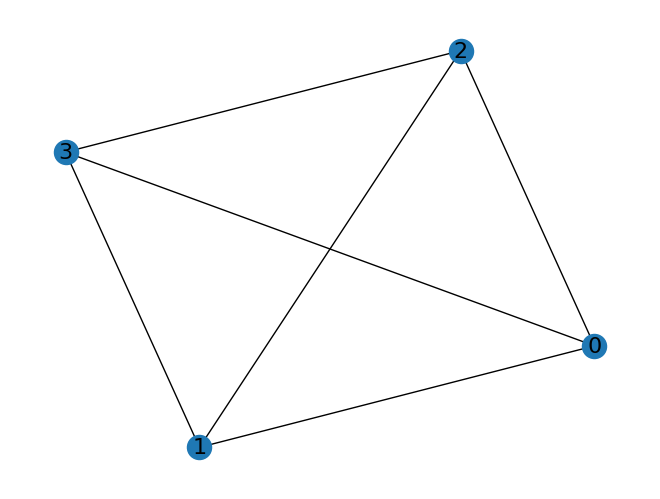

In [16]:
my_S = VietorisRipsComplex([(0, 0), (0, 1), (1, 1), (1, 0)], 1.5)
my_S.draw()
for i in range(7):
    print(f"{i}-th betti number: {my_S.betti_number(i)}")

0-th betti number: 1
1-th betti number: 0
2-th betti number: 0
3-th betti number: 0
4-th betti number: 0
5-th betti number: 0
6-th betti number: 0


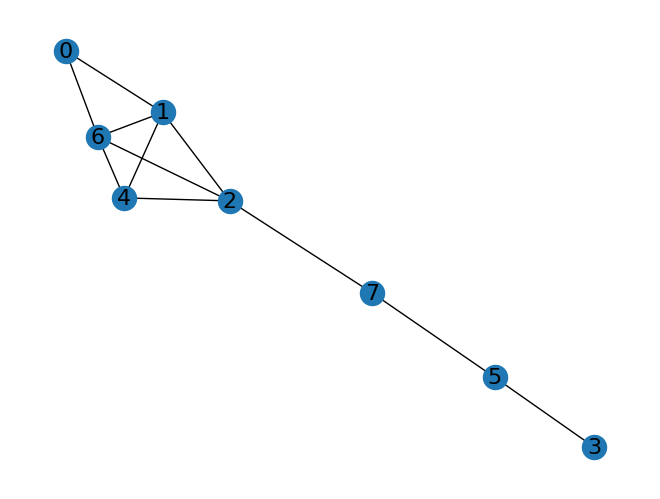

In [17]:
S = VietorisRipsComplex([(0, 1), (1, 2), (2, 3), (3, 0), (0, 4), (4, 1), (1, 3), (4, 3)], 2.5)
S.draw()
for i in range(7):
    print(f"{i}-th betti number: {S.betti_number(i)}")

### Числа Бетти алгоритмом из книги Эдельсбруннера и Харера

In [18]:
class ComputingBetti:
    def __init__(self, vector_points, eps: float = 0):
        self.vector_points = vector_points
        self.eps = eps
        self.simplicial_complex = VietorisRipsComplex(self.vector_points, self.eps)
        self.all_subsets_SC = self._get_subsets()

    def _get_subsets(self) -> list:
        sets = []
        for simplex in self.simplicial_complex.face_set:
            len_s = len(simplex)
            for i in range(1 << len_s):
                subset = {simplex[bit] for bit in range(len_s) if i & (1 << bit)}
                if len(subset) and (subset not in sets):
                    sets.append(subset)
        for i in range(len(sets)):
            sets[i] = set(sets[i])
        return sets

    def rank_Z2(self, matrix: np.matrix) -> int:
        n, m = matrix.shape
        rk = 0
        for i in range(m):
            if rk == min(n, m):
                break
            k = matrix[rk:, i].argmax() + rk
            if matrix[k, i] == 0:
                continue
            if k != rk:
                for col in range(i, m):
                    matrix[rk, col], matrix[k, col] = matrix[k, col], matrix[rk, col]
            for row in range(rk + 1, n):
                if matrix[row, i]:
                    for col in range(i, m):
                        matrix[row, col] = matrix[row, col] ^ matrix[rk, col]
            rk += 1
        return rk

    def count_betti_number(self, n: int = 0) -> int:
        n += 1
        np1_comlexes_id = [i for i in range(len(self.all_subsets_SC)) if len(self.all_subsets_SC[i]) == (n + 1)]
        n_comlexes_id = [i for i in range(len(self.all_subsets_SC)) if len(self.all_subsets_SC[i]) == n]
        nm1_comlexes_id = [i for i in range(len(self.all_subsets_SC)) if len(self.all_subsets_SC[i]) == (n - 1)]
        cnt_np1 = len(np1_comlexes_id)
        cnt_n = len(n_comlexes_id)
        cnt_nm1 = len(nm1_comlexes_id)

        Z_p = 0
        B_p = 0

        if cnt_nm1 == 0:
            Z_p = cnt_n
        elif cnt_n != 0 and cnt_nm1 != 0:
            boundary_matrix = np.matrix(data=[[0] * cnt_n for _ in range(cnt_nm1)], dtype=bool)
            for i in range(cnt_nm1):
                for j in range(cnt_n):
                    if len(self.all_subsets_SC[nm1_comlexes_id[i]].intersection(
                            self.all_subsets_SC[n_comlexes_id[j]])) == n - 1:
                        boundary_matrix[i, j] = 1
            Z_p = cnt_n - self.rank_Z2(boundary_matrix)

        if cnt_n == 0:
            B_p = cnt_np1
        elif cnt_np1 != 0 and cnt_n != 0:
            boundary_matrix = np.matrix(data=[[0] * cnt_np1 for _ in range(cnt_n)], dtype=int)
            for i in range(cnt_n):
                for j in range(cnt_np1):
                    if len(self.all_subsets_SC[n_comlexes_id[i]].intersection(
                            self.all_subsets_SC[np1_comlexes_id[j]])) == n:
                        boundary_matrix[i, j] = 1
            B_p = self.rank_Z2(boundary_matrix)

        return Z_p - B_p

##### Примеры

0 6
1 0
2 0
3 0
4 0


C:\Users\grish\AppData\Local\Temp\ipykernel_15352\210318836.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], alpha=0.8, cmap=cm.Wistia)


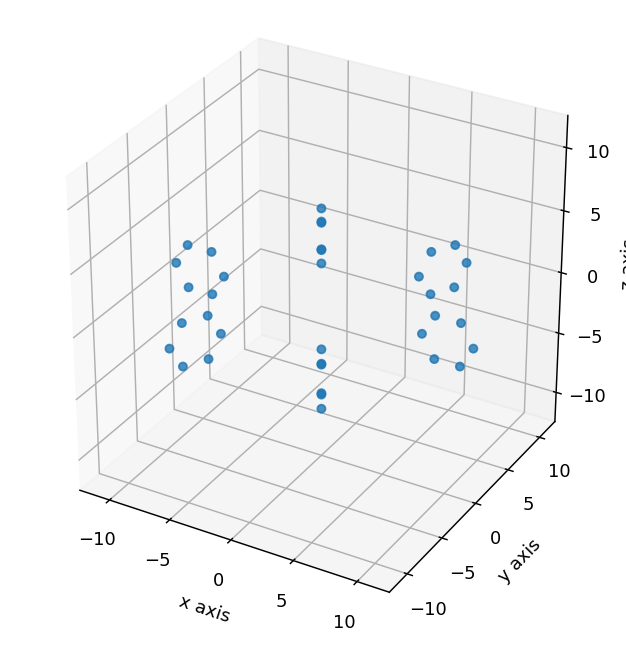

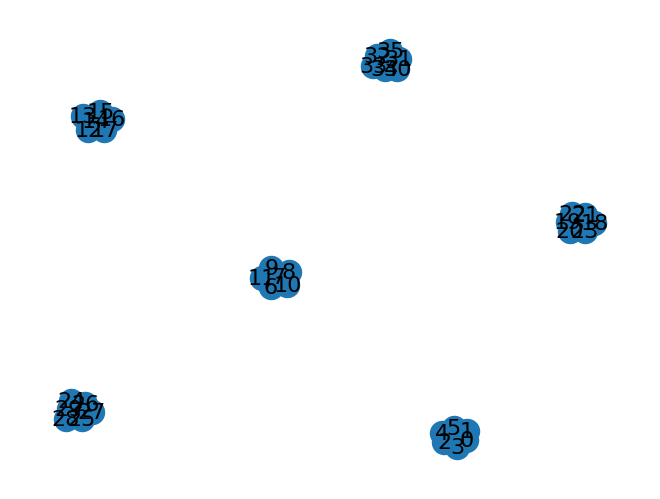

In [19]:
vector_points = get_torus_points(2, 10)
eps = 7
computing_betti = ComputingBetti(vector_points, eps)
for n in range(5):
    print(n, computing_betti.count_betti_number(n))

my_3d_draw(vector_points)
computing_betti.simplicial_complex.draw()

0 1
1 1
2 0
3 0
4 0


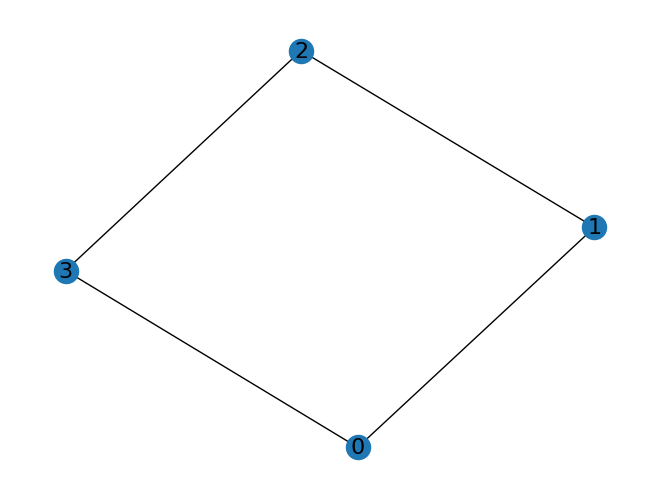

In [20]:
vector_points = [(0, 0), (0, 10), (10, 10), (10, 0)]
eps = 14
computing_betti = ComputingBetti(vector_points, eps)
for n in range(5):
    print(n, computing_betti.count_betti_number(n))

computing_betti.simplicial_complex.draw()

0 1
1 0
2 0
3 0
4 0


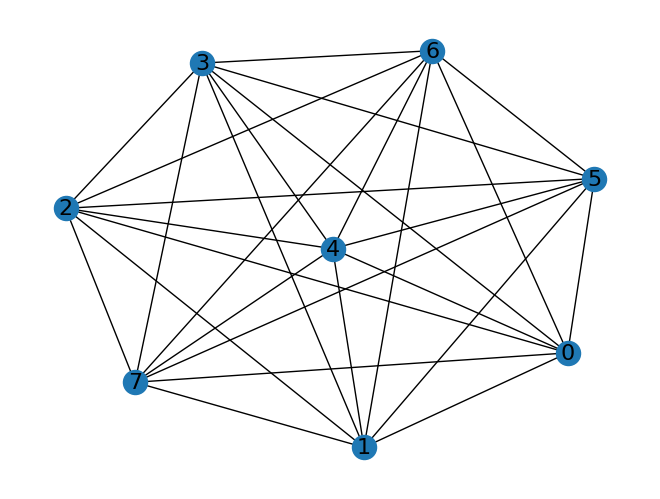

In [21]:
vector_points = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 1, 0), (1, 0, 1), (0, 1, 1), (1, 1, 1)]
eps = 2
computing_betti = ComputingBetti(vector_points, eps)
for n in range(5):
    print(n, computing_betti.count_betti_number(n))

computing_betti.simplicial_complex.draw()